In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt  # doctest: +SKIP
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

In [2]:
features = ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']

def data_split(dataSet) :
    dataSet_X = dataSet.drop('No-show', axis = 1)
    dataSet_y = dataSet.drop(features, axis = 1)
    return dataSet_X, dataSet_y

In [3]:
# funzione che permette di dividere l'età in gruppi
def fascia_eta(dataSet):
    bins= [0,31,56,80,200]
    labels = [0, 1, 2, 3]
    
    dataSet['AgeGroup'] = pd.cut(dataSet['Age'], bins=bins, labels=labels, right=False)

In [4]:
# funzione che effettua la differenza tra le due date e riporta il risultato in millisecondi
def sottrai_data (row) :
    row['diffData'] = ((row.AppointmentDay - row.ScheduledDay).total_seconds() * 1000)
    return row

In [5]:
# funzione che permette di dividere la diff tra le due date in gruppi
def fascia_diffData(dataSet):
    bins= [-5.681600e+09, -2.987600e+07, 2.995910e+08, 1.238590e+09, 1.542714e+11]
    labels = [0, 1, 2, 3]
    
    dataSet['FasciadiffData'] = pd.cut(dataSet['diffData'], bins=bins, labels=labels, right=False)

In [6]:
# encoder che permette di mappare i valori in numeri così che sia più facile lavorarci
def enc_features(dataSet) :
    encoder = LabelEncoder()
    encoderColumns = ['PatientId', 'Gender', 'Neighbourhood', 'AppointmentDay']

    encoded = dataSet[encoderColumns].apply(encoder.fit_transform)
    
    dataSet = dataSet.drop('PatientId', axis = 1).drop('Gender', axis = 1).drop('Neighbourhood', axis = 1)
    dataSet = dataSet.drop('AppointmentDay', axis = 1)
    
    dataSet = dataSet.join(encoded)
    
    return dataSet


In [7]:
# path dei due file csv anche se inutile...zucchero sintattico
train_path = "train.csv"
test_path = "test.csv"

In [8]:
# carico i dati parsando le date
train = pd.read_csv(train_path, parse_dates=['ScheduledDay','AppointmentDay'], index_col=0)
test = pd.read_csv(test_path, parse_dates=['ScheduledDay','AppointmentDay'], index_col=0)

In [9]:
# divido le features dalla variabile obiettivo ('No-show')
train_X, train_y = data_split(train)
test_X, test_y = data_split(test)

In [10]:
# controllo che non esistano valori esplicitamente null nel trainSet
missing_val_count_by_column = (train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


In [11]:
# divido le età in 4 fasce
fascia_eta(train_X)
fascia_eta(test_X)

In [12]:
# effettuo la differenza tra la data della visita e quella del giorno di prenotazione
# magari qualcuno non si è presentato perchè ha prenotato troppo tempo prima e si è dimenticato...boh
train_X = train_X.apply(sottrai_data, axis = 'columns')
test_X = test_X.apply(sottrai_data, axis = 'columns')

In [13]:
train_X.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,AgeGroup,diffData
5821,5.554332e+13,5686868,F,2016-05-11 14:12:13+00:00,2016-05-13 00:00:00+00:00,55,JARDIM CAMBURI,0,0,0,0,0,0,1,1.216670e+08
30770,4.955162e+14,5668152,F,2016-05-06 08:34:32+00:00,2016-05-06 00:00:00+00:00,47,RESISTÊNCIA,0,0,0,0,0,0,1,-3.087200e+07
51346,5.541574e+13,5751493,F,2016-05-31 10:13:24+00:00,2016-05-31 00:00:00+00:00,56,JESUS DE NAZARETH,1,1,1,0,0,0,2,-3.680400e+07
3906,7.445846e+11,5732987,F,2016-05-24 13:07:59+00:00,2016-06-01 00:00:00+00:00,66,SÃO PEDRO,0,0,0,0,1,1,2,6.439210e+08
38879,5.395177e+13,5575893,F,2016-04-13 07:42:07+00:00,2016-05-13 00:00:00+00:00,0,JABOUR,0,0,0,0,0,0,0,2.564273e+09


In [14]:
# features encoder per le seguenti colonne: ['PatientId', 'Gender', 'Neighbourhood', 'AppointmentDay']

train_X = enc_features(train_X)
test_X = enc_features(test_X)

/home/davide/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:834: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  y = np.asarray(y)


In [15]:
train_X.head()

,AppointmentID,ScheduledDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,AgeGroup,diffData,PatientId,Gender,Neighbourhood,AppointmentDay
5821,5686868,2016-05-11 14:12:13+00:00,55,0,0,0,0,0,0,1,1.216670e+08,27733,0,38,10
30770,5668152,2016-05-06 08:34:32+00:00,47,0,0,0,0,0,0,1,-3.087200e+07,40591,0,58,5
51346,5751493,2016-05-31 10:13:24+00:00,56,1,1,1,0,0,0,2,-3.680400e+07,27704,0,40,20
3906,5732987,2016-05-24 13:07:59+00:00,66,0,0,0,0,1,1,2,6.439210e+08,6007,0,76,21
38879,5575893,2016-04-13 07:42:07+00:00,0,0,0,0,0,0,0,0,2.564273e+09,27382,0,37,10


In [16]:
# divido in gruppi la diff di data così che il gruppo con numero più alto abbia anche prenotazione più lontana
fascia_diffData(train_X)
fascia_diffData(test_X)

In [17]:
train_X.head()

,AppointmentID,ScheduledDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,AgeGroup,diffData,PatientId,Gender,Neighbourhood,AppointmentDay,FasciadiffData
5821,5686868,2016-05-11 14:12:13+00:00,55,0,0,0,0,0,0,1,1.216670e+08,27733,0,38,10,1
30770,5668152,2016-05-06 08:34:32+00:00,47,0,0,0,0,0,0,1,-3.087200e+07,40591,0,58,5,0
51346,5751493,2016-05-31 10:13:24+00:00,56,1,1,1,0,0,0,2,-3.680400e+07,27704,0,40,20,0
3906,5732987,2016-05-24 13:07:59+00:00,66,0,0,0,0,1,1,2,6.439210e+08,6007,0,76,21,2
38879,5575893,2016-04-13 07:42:07+00:00,0,0,0,0,0,0,0,0,2.564273e+09,27382,0,37,10,3


In [18]:
# per ogni colonna stampo i valori univoci in modo da assicurarmi che non ci siano valori strani
for col in train_X.columns :
    print("---", col, "---")
    print(train_X[col].unique())
    print("\n")

--- AppointmentID ---
[5686868 5668152 5751493 ... 5705220 5676714 5659135]


--- ScheduledDay ---
<DatetimeArray>
['2016-05-11 14:12:13+00:00', '2016-05-06 08:34:32+00:00',
 '2016-05-31 10:13:24+00:00', '2016-05-24 13:07:59+00:00',
 '2016-04-13 07:42:07+00:00', '2016-04-29 08:25:38+00:00',
 '2016-05-24 07:35:13+00:00', '2016-05-10 15:46:44+00:00',
 '2016-05-10 15:39:28+00:00', '2016-05-05 14:43:43+00:00',
 ...
 '2016-05-16 15:12:02+00:00', '2016-05-02 11:44:18+00:00',
 '2016-05-12 13:20:00+00:00', '2016-05-04 16:56:13+00:00',
 '2016-05-30 16:30:11+00:00', '2016-05-02 14:26:14+00:00',
 '2016-05-17 08:31:17+00:00', '2016-04-07 14:43:23+00:00',
 '2016-05-17 06:56:39+00:00', '2016-05-09 16:19:05+00:00']
Length: 67687, dtype: datetime64[ns, UTC]


--- Age ---
[ 55  47  56  66   0  16  46  19  29  35  40  20  54  73  38   8  59   2
   7  63  17  44  48  39  76  30  13  12  78  45  58  52  28  67  53  61
  65  24  68   5  43   3  34  84  49  89  81  69  27  37   1  41   9  11
  18  42  75  3

In [19]:
train_X.columns

Index(['AppointmentID', 'ScheduledDay', 'Age', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'AgeGroup',
       'diffData', 'PatientId', 'Gender', 'Neighbourhood', 'AppointmentDay',
       'FasciadiffData'],
      dtype='object')

In [20]:
# sono molto indeciso tra quali features usare, ma scarterò: 
# 'AppointmentID' perchè univoco;
# 'Age' perchè ormai ho 'AgeGroup'; 
# 'PatientId' perchè anche se magari non si è presentato una volta, non credo ci sia una correlazione così forte con 'No-show'; 
# 'ScheduledDay' perchè tutti valori univoci avendo anche i millisecondi nel timestamp (avevo anche provato a dividerli in mese e giorno, ma il modello si overfitta); 'AppointmentDay'  
# 'AppointmentDay' perchè ho usato la diff tra visita e prenotazione
# 'Neighbourhood' non credo ci sia una correlazione tra quartiere e persone che non si fanno visitare

cols = ['Scholarship', 'Hipertension', 'AgeGroup',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'Gender', 'FasciadiffData']

In [23]:
# 42 because that is the meaning of life
clf = DecisionTreeClassifier(random_state=42)
# Train Decision Tree Classifer
clf = clf.fit(train_X[cols] , train_y)
#Predict the response for test dataset

print("Accuracy on training set: {:.3f}".format(clf.score(train_X[cols], train_y)))
print("Accuracy on test set: {:.3f}".format(clf.score(test_X[cols], test_y)))

Accuracy on training set: 0.801
Accuracy on test set: 0.791


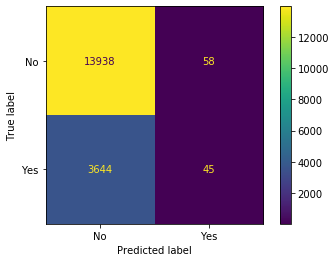

In [22]:
# plot che mi dice quanti valori sono stati classificati correttamente e non

plot_confusion_matrix(clf, test_X[cols], test_y)  # doctest: +SKIP
plt.show()